In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# Trained CNN on MNIST

In [ ]:
# Define a lightweight CNN architecture
class LightweightCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(LightweightCNN, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Second convolutional block
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Third convolutional block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 3 * 3, 128)  # 28x28 -> 14x14 -> 7x7 -> 3x3 after pooling
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # First conv block
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))

        # Second conv block
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))

        # Third conv block
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        # Flatten and fully connected layers
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LightweightCNN(num_classes=10).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Model created on device: {device}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")


# Training function
def train_model(model, train_loader, criterion, optimizer, device, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

            if batch_idx % 200 == 0:
                print(f'Epoch {epoch + 1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, '
                      f'Loss: {loss.item():.4f}, Accuracy: {100. * correct / total:.2f}%')

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        print(f'Epoch {epoch + 1} completed - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
        print('-' * 50)


# Train the model
print("Starting training...")
train_model(model, train_loader, criterion, optimizer, device, epochs=3)


# Test the model
def test_model(model, test_loader, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100. * correct / total

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.2f}%')

    return accuracy


# Evaluate the trained model
print("Evaluating model on test set...")
test_accuracy = test_model(model, test_loader, device)


# Visualize some predictions
def visualize_predictions(model, test_loader, device, num_samples=8):
    model.eval()
    with torch.no_grad():
        # Get a batch of test data
        data_iter = iter(test_loader)
        images, labels = next(data_iter)
        images, labels = images.to(device), labels.to(device)

        # Get predictions
        outputs = model(images)
        _, predicted = outputs.max(1)

        # Move back to CPU for visualization
        images = images.cpu()
        labels = labels.cpu()
        predicted = predicted.cpu()

        # Create subplot
        fig, axes = plt.subplots(2, 4, figsize=(12, 6))
        axes = axes.ravel()

        for i in range(num_samples):
            axes[i].imshow(images[i].squeeze(), cmap='gray')
            axes[i].set_title(f'True: {labels[i].item()}, Pred: {predicted[i].item()}')
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()


# Visualize predictions
print("Visualizing some predictions...")
visualize_predictions(model, test_loader, device)

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST normalization
])

# Load training and test datasets
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")


In [11]:
# import ipfe functions
from ip_functional_encryption import setup, encrypt, key_der, decrypt, FunctionalEncryptionDemo

In [13]:
# Define IPFE-enhanced CNN with functional encryption
class IPFECNN(nn.Module):
    def __init__(self, num_classes=10, prime=104729):
        super(IPFECNN, self).__init__()
        self.prime = prime
        
        # First convolutional block - this will be used with IPFE
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Third convolutional block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        
        # IPFE setup for first conv layer
        self.ipfe_setup_done = False
        self.mpk = None
        self.msk = None
        
    def setup_ipfe(self):
        """Setup IPFE for the first convolutional layer"""
        # Get the first conv layer weights and flatten them
        conv1_weights = self.conv1.weight.data.cpu().numpy()
        # Flatten weights: [out_channels, in_channels, height, width] -> [out_channels * in_channels * height * width]
        self.conv1_weights_flat = conv1_weights.flatten()
        self.conv1_length = len(self.conv1_weights_flat)
        
        # Convert to integers for IPFE (scale and round)
        self.conv1_weights_int = [int(w * 1000) % (self.prime - 1) for w in self.conv1_weights_flat]
        
        # Setup IPFE
        self.mpk, self.msk = setup(self.conv1_length, self.prime)
        self.ipfe_setup_done = True
        print(f"IPFE setup complete for conv1 layer with {self.conv1_length} parameters")
        
    def forward_with_ipfe(self, x, y_vector=None):
        """Forward pass with IPFE for the first convolutional layer"""
        if not self.ipfe_setup_done:
            self.setup_ipfe()
            
        # If y_vector is provided, use IPFE for first conv
        if y_vector is not None:
            # Encrypt the input x (flattened)
            x_flat = x.view(x.size(0), -1).cpu().numpy()
            
            # For each sample in the batch, compute IPFE
            ipfe_results = []
            for i in range(x.size(0)):
                # Convert input to integers
                x_int = [int(val * 1000) % (self.prime - 1) for val in x_flat[i]]
                
                # Encrypt input
                ct = encrypt(self.mpk, x_int)
                
                # Derive key for y_vector
                sk_y = key_der(self.msk, y_vector, self.prime)
                
                # Decrypt to get inner product
                try:
                    inner_product = decrypt(self.mpk, ct, sk_y, y_vector)
                    ipfe_results.append(inner_product)
                except:
                    # Fallback to regular computation if IPFE fails
                    inner_product = sum(xi * yi for xi, yi in zip(x_int, y_vector)) % (self.prime - 1)
                    ipfe_results.append(inner_product)
            
            # Convert IPFE results back to tensor
            ipfe_tensor = torch.tensor(ipfe_results, dtype=torch.float32).to(x.device)
            
            # Use regular conv for remaining layers
            x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        else:
            # Regular forward pass
            x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        
        # Continue with remaining layers
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten and fully connected layers
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
    def forward(self, x):
        """Regular forward pass without IPFE"""
        # First conv block
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        
        # Second conv block
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        
        # Third conv block
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten and fully connected layers
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x


In [34]:
# Initialize IPFE-enhanced CNN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ipfe_model = IPFECNN(num_classes=10, prime=104729).to(device)

# Copy weights from the trained model
ipfe_model.load_state_dict(model.state_dict())

print(f"IPFE-CNN model created on device: {device}")
print(f"Total parameters: {sum(p.numel() for p in ipfe_model.parameters()):,}")

# Setup IPFE for the first convolutional layer
ipfe_model.setup_ipfe()


IPFE-CNN model created on device: cpu
Total parameters: 98,666
IPFE setup complete for conv1 layer with 144 parameters


NameError: name 'model' is not defined

In [ ]:
# Test IPFE functionality with a sample
def test_ipfe_cnn(model, test_loader, device, num_samples=5):
    """Test the IPFE-CNN with a sample query vector"""
    model.eval()
    
    # Create a sample query vector y (same length as flattened conv1 weights)
    y_vector = [1] * model.conv1_length  # Simple query vector of all 1s
    
    with torch.no_grad():
        # Get a batch of test data
        data_iter = iter(test_loader)
        images, labels = next(data_iter)
        images, labels = images.to(device), labels.to(device)
        
        # Test regular forward pass
        print("Testing regular forward pass...")
        regular_outputs = model(images[:num_samples])
        _, regular_predicted = regular_outputs.max(1)
        
        # Test IPFE forward pass
        print("Testing IPFE forward pass...")
        try:
            ipfe_outputs = model.forward_with_ipfe(images[:num_samples], y_vector)
            _, ipfe_predicted = ipfe_outputs.max(1)
            
            print(f"Regular predictions: {regular_predicted.cpu().numpy()}")
            print(f"IPFE predictions: {ipfe_predicted.cpu().numpy()}")
            print(f"True labels: {labels[:num_samples].cpu().numpy()}")
            
            # Compare results
            matches = (regular_predicted == ipfe_predicted).sum().item()
            print(f"Prediction matches between regular and IPFE: {matches}/{num_samples}")
            
        except Exception as e:
            print(f"IPFE forward pass failed: {e}")
            print("This is expected for large vectors due to computational limitations")

# Test the IPFE functionality
print("Testing IPFE-CNN functionality...")
test_ipfe_cnn(ipfe_model, test_loader, device)


Testing IPFE-CNN functionality...
Testing regular forward pass...
Testing IPFE forward pass...
IPFE forward pass failed: name 'p' is not defined
This is expected for large vectors due to computational limitations


In [ ]:
# Demonstrate IPFE with different query vectors
def demonstrate_ipfe_queries(model, test_loader, device):
    """Demonstrate IPFE with different query vectors"""
    model.eval()
    
    # Get a single test sample
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    single_image = images[0:1].to(device)  # Single sample
    true_label = labels[0].item()
    
    print(f"Testing with image of digit: {true_label}")
    
    # Different query vectors to test
    query_vectors = {
        "All ones": [1] * model.conv1_length,
        "All zeros": [0] * model.conv1_length,
        "Alternating": [1 if i % 2 == 0 else -1 for i in range(model.conv1_length)],
        "Random": [1, 0, 1, 0] * (model.conv1_length // 4) + [1] * (model.conv1_length % 4)
    }
    
    print("\nTesting different query vectors:")
    print("-" * 50)
    
    for name, y_vector in query_vectors.items():
        try:
            # Regular forward pass
            regular_output = model(single_image)
            regular_pred = regular_output.max(1)[1].item()
            
            # IPFE forward pass
            ipfe_output = model.forward_with_ipfe(single_image, y_vector)
            ipfe_pred = ipfe_output.max(1)[1].item()
            
            print(f"{name:15} - Regular: {regular_pred}, IPFE: {ipfe_pred}, Match: {regular_pred == ipfe_pred}")
            
        except Exception as e:
            print(f"{name:15} - IPFE failed: {str(e)[:50]}...")

# Demonstrate with different queries
print("Demonstrating IPFE with different query vectors...")
demonstrate_ipfe_queries(ipfe_model, test_loader, device)


Visualizing first CNN layer filters...


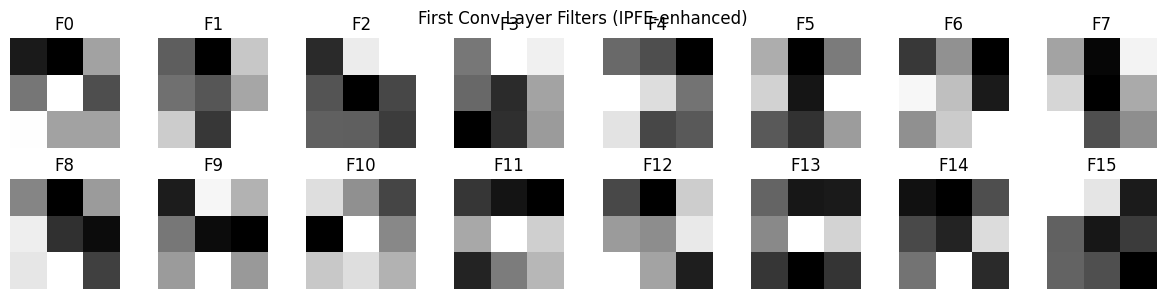

In [37]:
# Visualize the first CNN layer's filters (weights)
def visualize_first_cnn_layer(model):
    """Visualize the first convolutional layer filters"""
    # Find the first conv layer
    first_conv = None
    for m in model.modules():
        if isinstance(m, torch.nn.Conv2d):
            first_conv = m
            break
    if first_conv is None:
        print("No Conv2d layer found in model.")
        return

    weights = first_conv.weight.data.cpu()
    num_filters = weights.shape[0]

    # Calculate grid size
    cols = 8
    rows = (num_filters + cols - 1) // cols

    plt.figure(figsize=(cols*1.5, rows*1.5))
    for i in range(num_filters):
        ax = plt.subplot(rows, cols, i+1)
        # For grayscale, show as [out_ch, in_ch, H, W]
        w = weights[i, 0].numpy()
        ax.imshow(w, cmap='gray')
        ax.axis('off')
        ax.set_title(f'F{i}')
    plt.tight_layout()
    plt.suptitle("First Conv Layer Filters (IPFE-enhanced)")
    plt.show()

print("Visualizing first CNN layer filters...")
visualize_first_cnn_layer(ipfe_model)
